<a href="https://colab.research.google.com/github/vamosya/data_notebooks_python/blob/main/GarminActivitiesTotalAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [105]:
pip install garminconnect

In [106]:
pip install reverse_geocoder

In [107]:
pip install squarify

In [108]:
pip install ggplot

In [109]:
# Librerias necesarias
from garminconnect import Garmin
from getpass import getpass
import logging
import matplotlib.pyplot as plt
import math
import pandas as pd
import reverse_geocoder as rg
import squarify
import warnings
import numpy as np
warnings.filterwarnings("ignore")
%matplotlib inline  

# Descargar y generar df

In [159]:
# Conexión a Garmin Connect
paswd = getpass()
client = Garmin("cperaltap@gmail.com", paswd)
client.login()
print("Hola {}! Estás dentro!!".format(client.get_full_name()))

··········
Hola Carlos! Estás dentro!!


In [160]:
# Bajar actividades
activities = client.get_activities(0,2000) # tope de 2000. Se puede modificar

# guardo en un dataframe de Pandas
activities = pd.DataFrame(activities)


# ordeno
#activities = activities.sort_values(by='startTimeLocal')

# Muestro id de la primera actividad
activities['activityId'][0]

7796634652

# Limpieza

In [112]:
# Para tener los deportes, primero creo una columna
# Extraer de ActivityType el deporte y añadirlo a columna
sports = []
for i in range(len(activities)):
  sports.append(activities['activityType'][i]['typeKey'])
activities['sport'] = sports

sportsParentNumber = []
for i in range(len(activities)):
  sportsParentNumber.append(activities['activityType'][i]['parentTypeId'])
activities['sportParentNumber'] = sportsParentNumber


activities['sportParent'] = ""
sportParent_dict = {2: 'cycling', 17: 'running_walking', 4: 'rowing_paddling_skating', 26: 'swimming', 1: 'running', 29: 'gym', 165: 'skating', 9: 'walking'}
for i in range(len(activities)):
  activities['sportParent'][i] = sportParent_dict[activities.sportParentNumber[i]]
  if activities.sport[i] == 'running':
    activities['sportParent'][i] = 'running'
  elif activities.sport[i] == 'hiking':
    activities['sportParent'][i] = 'walking'
  elif activities.sport[i] == 'rowing':
    activities['sportParent'][i] = 'rowing'
  elif activities.sport[i] == 'paddling':
    activities['sportParent'][i] = 'paddle_surf'
  elif activities.sport[i] == 'inline_skating':
    activities['sportParent'][i] = 'inline_skate'
  elif activities.sport[i] == 'cycling':
    activities['sportParent'][i] = 'cycling'
  elif activities.sport[i] == 'walking':
    activities['sportParent'][i] = 'walking'
  elif activities.sport[i] == 'swimming':
    activities['sportParent'][i] = 'swimming'
  elif activities.sport[i] == 'other':
    activities['sportParent'][i] = 'other'
  elif activities.sport[i] == 'fitness_equipment':
    activities['sportParent'][i] = 'gym'
  elif activities.sport[i] == 'stand_up_paddleboarding':
    activities['sportParent'][i] = 'paddle_surf'
  elif activities.sport[i] == 'tennis':
    activities['sportParent'][i] = 'other'
  elif activities.sport[i] == 'boating':
    activities['sportParent'][i] = 'other'
  elif activities.sport[i] == 'rock_climbing':
    activities['sportParent'][i] = 'other'
    

In [113]:
# Hago un describe de los datos
activities.describe()
activities[['sport', 'sportParent','startTimeLocal']]

,sport,sportParent,startTimeLocal
0,running,running,2021-11-10 11:36:34
1,running,running,2021-11-09 10:43:36
2,hiking,walking,2021-11-05 10:14:46
3,running,running,2021-10-24 09:17:28
4,running,running,2021-10-22 10:59:30
...,...,...,...
1125,running,running,2012-09-12 20:30:24
1126,running,running,2012-09-10 19:52:04
1127,walking,walking,2012-09-09 10:31:00
1128,running,running,2012-09-08 14:11:07


In [114]:
# Veo los que tienen todos sus valores nan y son más de la mitad por lo que los elimino
activities_nan = activities.isnull().sum().sort_values(ascending = False)
activities_nan_dict = activities_nan.to_dict()
lista_no_nan = []
for k, v in activities_nan_dict.items():
  if v != len(activities.index):
    lista_no_nan.append(k)
# Me quedo solo con las que hay en la lista
activities = activities[activities.columns.intersection(lista_no_nan)]
print("quedan {} columnas".format(len(activities.columns)))

quedan 91 columnas


In [115]:
# Calculo columnas de distancia en km, duración en horas y velocidad en km/h
activities['averageSpeedKmh'] = round(activities.averageSpeed*3.6,1)
activities['distanceKm'] = round(activities.distance/1000,1)
activities['durationHours'] = round(activities.duration/3600,2)

# Localizaciones

In [116]:
# Redondeo para que haya menos casos diferentes a la hora de calcular las localizaciones
activities = activities.round({'startLatitude': 3})
activities = activities.round({'startLongitude': 3})

# Paso a string para trabajar mejor con los nan
activities['startLatitude'] = activities['startLatitude'].astype(str)
activities['startLongitude'] = activities['startLongitude'].astype(str)

# Sustituyo nan por 0.0
activities['startLatitude'].replace({"nan": "0.0"}, inplace=True)
activities['startLongitude'].replace({"nan": "0.0"}, inplace=True)

# Reseteo el index para facilitar iteración
activities.reset_index(drop=True, inplace=True)
activities.activityId

0       7796634652
1       7793943113
2       7772796376
3       7707003773
4       7697323505
           ...    
1125     853617665
1126     853617810
1127     853617944
1128     853618102
1129    2458506886
Name: activityId, Length: 1130, dtype: int64

In [117]:
# Creo la tupla necesaria para buscar después
activities['tupleLocation'] = activities[["startLatitude","startLongitude"]].apply(tuple, axis=1)
activities['tupleLocation'].value_counts()

(40.562, -3.622)    428
(0.0, 0.0)          313
(40.236, -4.385)     51
(40.566, -3.629)     20
(40.563, -3.621)     19
                   ... 
(36.862, -2.005)      1
(40.734, -3.876)      1
(41.042, -3.99)       1
(40.398, -4.38)       1
(40.56, -3.621)       1
Name: tupleLocation, Length: 167, dtype: int64

In [118]:
# Creo lista de ubicaciones únicas para hacer cache
cacheLocs = []
for i in range(len(activities)):
  cacheLocs.append(activities['tupleLocation'][i])
cacheLocs = list(set(cacheLocs))

# Creo el diccionario con estas ubicaciones únicas y su resultado.
tempLocs = {}
for i in range(len(cacheLocs)):
  tempLocs[cacheLocs[i]] = rg.search(cacheLocs[i])
tempLocs

# Inicializo las columnas nuevas
activities['cityLoc'] = ""
activities['provinceLoc'] = ""
activities['regionLoc'] = ""
activities['countryLoc'] = ""

# Itero para ir añadiendo los resultados a las columnas
for i in range(len(activities)):
  coordinates = activities['tupleLocation'][i]
  activities['cityLoc'][i] = tempLocs[coordinates][0]['name']
  activities['provinceLoc'][i] = tempLocs[coordinates][0]['admin1']
  activities['regionLoc'][i] = tempLocs[coordinates][0]['admin2']
  activities['countryLoc'][i] = tempLocs[coordinates][0]['cc']

# Muestro las regiones únicas donde hay actividades
activities.regionLoc.unique()

array(['Provincia de Madrid', 'Provincia de Huelva', 'Silves',
       'Albufeira', 'Province of Toledo', 'Provincia de Valencia', '',
       'Provincia de Alicante', 'Provincia de Castello',
       'Provincia de Almeria', 'Provincia de Guadalajara',
       'Provincia de Segovia', 'Provincia de Cadiz',
       'Provincia de Burgos', 'Greater London', 'Murcia'], dtype=object)

# Fechas

In [119]:
# Paso la columna a datetime
activities.startTimeLocal = pd.to_datetime(activities.startTimeLocal)

activities['weekDayDate'] = activities.startTimeLocal.dt.day_name()
activities['hourDate'] = activities.startTimeLocal.dt.hour
activities['monthNameDate'] = activities.startTimeLocal.dt.month_name()
activities['monthNumberDate'] = activities.startTimeLocal.dt.month
activities['yearDate'] = activities.startTimeLocal.dt.year
activities['activityDate'] = activities.startTimeLocal.dt.date
activities['yearDayDate'] = activities.startTimeLocal.dt.dayofyear

In [120]:
# Creo nuevas columnas que puedo utilizar en el futuro

# Columna fin de semana (weekend) 1 si 0 no
activities['weekendActivity'] = 0
weekendDays = ['Saturday','Sunday']
activities.loc[activities['weekDayDate'].isin(weekendDays), 'weekendActivity'] = 1
activities[['weekDayDate', 'weekendActivity']]

# Columna mañana-tarde hasta las 14:00 (morning) 1 si 0 no
activities['morningActivity'] = 1
activities.loc[activities.hourDate > 14, 'morningActivity'] = 0
activities[['hourDate', 'morningActivity']]

,hourDate,morningActivity
0,11,1
1,10,1
2,10,1
3,9,1
4,10,1
...,...,...
1125,20,0
1126,19,0
1127,10,1
1128,14,1


# Estadística multideporte

In [121]:
# Establezco las listas de dias y meses para cuando las necesite ordenadas
days = ['Monday', 'Tuesday' , 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday' ]

months = ['January', 'February', 'March',
         'April','May', 'June',
         'July', 'August', 'September',
         'October', 'November', 'December']

#### Hago un Treemap con el tiempo dedicado a cada deporte

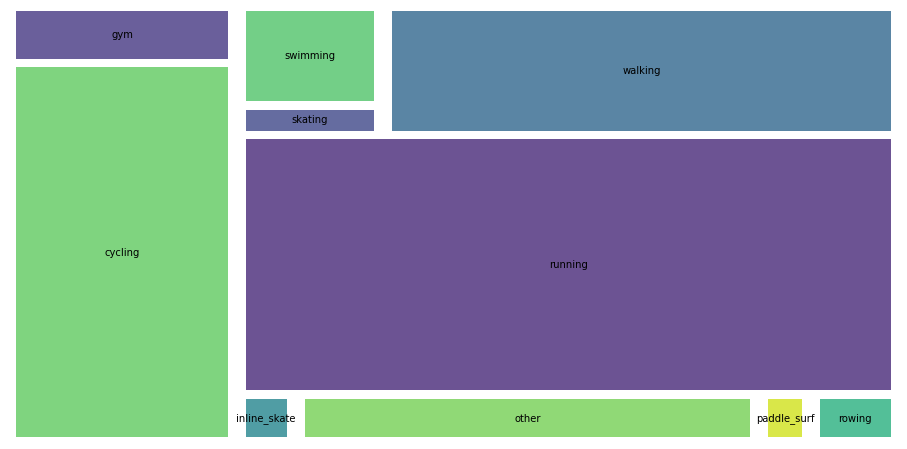

<Figure size 1080x576 with 0 Axes>

In [122]:
# Treemap duracion por deporte
by_sport = activities.groupby('sportParent').sum()
fig = plt.gcf()
fig.set_size_inches(16, 8)
squarify.plot(sizes = by_sport.durationHours, 
              label = by_sport.index, 
              alpha=.8, pad=True,
              text_kwargs={'fontsize':10})
plt.axis('off')
plt.figure(figsize=(15,8))
plt.show() 

#### Treemap con las sesiones realizadas por cada deporte

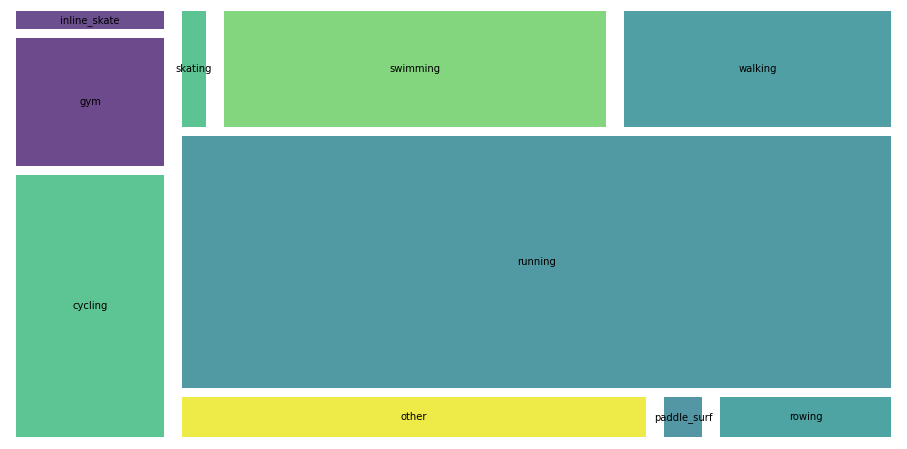

In [123]:
# Treemap número de sesiones por deporte
by_sport = activities.groupby('sportParent').count()
by_sport
fig = plt.gcf()
fig.set_size_inches(16, 8)
squarify.plot(sizes = by_sport.activityId, 
              label = by_sport.index, 
              alpha=.8, pad=True,
              text_kwargs={'fontsize':10})
plt.axis('off')
plt.show() 

#### Gráfico de puntos relacionando distancia y duración y marco en colores los deportes para diferenciarlos. Guardo comentada una estática y creo una interactiva con plotly.

In [124]:
# Estática
#sns.scatterplot('distanceKm', 'durationHours', data=activities, hue='sportParent')
#plt.figure(figsize=(15,8))
#plt.show()

import plotly.express as px
fig = px.scatter(activities, x="distanceKm", y="durationHours", color="sportParent",
                 hover_data=['activityDate'], trendline = 'lm')
fig.show()

# Estadística running



In [125]:
# Analizar los datos de un deporte
activities_run = activities[activities['sportParent'] == "running"]
activities_run = activities_run.reset_index()

# Muestro estadísticos
activities_run.describe()

,index,activityId,distance,duration,elapsedDuration,movingDuration,elevationGain,elevationLoss,averageSpeed,maxSpeed,ownerId,calories,averageHR,maxHR,averageRunningCadenceInStepsPerMinute,maxRunningCadenceInStepsPerMinute,averageBikingCadenceInRevPerMinute,maxBikingCadenceInRevPerMinute,averageSwimCadenceInStrokesPerMinute,maxSwimCadenceInStrokesPerMinute,averageSwolf,activeLengths,steps,courseId,poolLength,timeZoneId,beginTimestamp,sportTypeId,aerobicTrainingEffect,strokes,avgStrideLength,vO2MaxValue,maxFtp,avgStrokeDistance,maxStrokeCadence,avgStrokes,deviceId,minTemperature,minElevation,maxElevation,maxDoubleCadence,maxDepth,avgDepth,surfaceInterval,avgVerticalSpeed,maxVerticalSpeed,floorsDescended,bottomTime,lapCount,endLatitude,endLongitude,totalSets,activeSets,totalReps,minActivityLapDuration,sportParentNumber,averageSpeedKmh,distanceKm,durationHours,hourDate,monthNumberDate,yearDate,yearDayDate,weekendActivity,morningActivity
count,553.000000,5.530000e+02,553.000000,553.000000,407.000000,341.000000,538.000000,539.000000,553.000000,548.000000,553.0,553.000000,520.000000,520.000000,358.000000,358.000000,0.0,0.0,0.0,0.0,0.0,0.0,358.000000,0.0,0.0,553.000000,5.530000e+02,400.000000,232.000000,0.0,357.000000,204.000000,166.0,0.0,0.0,0.0,4.310000e+02,0.0,449.000000,449.000000,359.000000,0.0,0.0,0.0,92.0,345.000000,0.0,0.0,327.000000,36.000000,36.000000,0.0,0.0,0.0,226.000000,553.000000,553.000000,553.000000,553.000000,553.000000,553.000000,553.000000,553.000000,553.000000,553.000000
mean,516.672694,3.238316e+09,6769.095165,2415.516127,2559.723953,2484.803742,63.344119,64.569666,2.833469,5.078566,11836323.0,436.146349,135.801088,158.411538,169.132071,185.662011,NaN,NaN,NaN,NaN,NaN,NaN,6900.446927,NaN,NaN,124.320072,1.527724e+12,0.980000,3.010776,NaN,101.259874,50.073529,172.0,NaN,NaN,NaN,3.917348e+09,NaN,594.857158,642.535010,185.147632,NaN,NaN,NaN,0.0,1.275133,NaN,NaN,8.030581,40.551335,-3.673997,NaN,NaN,NaN,76.399102,16.710669,10.201085,6.759494,0.670958,11.802893,6.734177,2017.895118,188.981917,0.385172,0.739602
std,339.108229,2.032679e+09,2480.011650,993.324680,937.539108,808.442509,41.423474,42.196295,0.383807,5.536652,0.0,174.182202,38.819468,43.517629,6.224722,18.022714,NaN,NaN,NaN,NaN,NaN,NaN,2265.273237,NaN,NaN,3.084072,6.581466e+10,0.140175,0.927089,NaN,11.825053,2.780914,0.0,NaN,NaN,NaN,3.810651e+08,NaN,162.914427,176.003663,20.466977,NaN,NaN,NaN,0.0,4.574328,NaN,NaN,2.213798,0.088938,0.183788,NaN,NaN,NaN,94.781550,2.133967,1.381332,2.477870,0.275913,4.208668,3.189636,2.095508,96.523368,0.487076,0.439249
min,0.000000,8.535946e+08,530.000000,201.000000,205.054993,284.386993,0.000000,0.000000,0.000000,1.754000,11836323.0,0.000000,0.000000,0.000000,113.218750,129.000000,NaN,NaN,NaN,NaN,NaN,NaN,576.000000,NaN,NaN,120.000000,1.347106e+12,0.000000,1.100000,NaN,21.795065,44.000000,172.0,NaN,NaN,NaN,0.000000e+00,NaN,-19.000000,3.200000,1.000000,NaN,NaN,NaN,0.0,0.000000,NaN,NaN,1.000000,40.235491,-4.385244,NaN,NaN,NaN,1.527000,1.000000,0.000000,0.500000,0.060000,4.000000,1.000000,2012.000000,2.000000,0.000000,0.000000
25%,220.000000,1.468180e+09,5143.040039,1885.000000,2140.029973,2104.000000,36.947500,37.950000,2.649000,3.387000,11836323.0,343.912440,136.000000,159.000000,167.941406,176.000000,NaN,NaN,NaN,NaN,NaN,NaN,5684.500000,NaN,NaN,124.000000,1.476602e+12,1.000000,2.300000,NaN,94.241593,48.000000,172.0,NaN,NaN,NaN,3.933221e+09,NaN,631.599976,664.710000,176.000000,NaN,NaN,NaN,0.0,0.310573,NaN,NaN,7.000000,40.561550,-3.622809,NaN,NaN,NaN,6.865000,17.000000,9.500000,5.100000,0.520000,9.000000,4.000000,2016.000000,107.000000,0.000000,0.000000
50%,486.000000,2.883646e+09,7009.000000,2407.497070,2512.031000,2463.918976,57.183827,59.405273,2.867000,3.853500,11836323.0,431.978845,146.000000,171.000000,170.132812,180.000000,NaN,NaN,NaN,NaN,NaN,NaN,7029.000000,NaN,NaN,124.000000,1.532668e+12,1.000000,3.100000,NaN,101.609012,50.000000,172.0,NaN,NaN,NaN,3.982780e+09,NaN,639.295166,681.171265,180.000000,NaN,NaN,NaN,0.0,0.416306,NaN

In [126]:
# Mayor distancia
activities_run.distanceKm.max()

21.4

In [127]:
# Media de frecuencia cardiaca
activities_run.averageHR.mean()

135.80108831620132

In [128]:
# Media de velocidad en distancias entre 9 y 12 km
activities_run.averageSpeedKmh[activities.distanceKm.between(9 , 12)].mean()

10.418666666666669

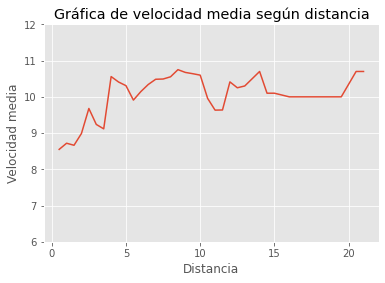

<Figure size 1080x576 with 0 Axes>

In [130]:
# Cálculo y gráfica de la velocidad media a través de la distancia de las sesiones
avg_by_distances = []
distance_list = []
n = 0.5
while n < activities_run.distanceKm.max()+0.5:
  avg_by_distances.append(activities_run.averageSpeedKmh[activities_run.distanceKm.between(n,n+1)].mean())
  distance_list.append(n)
  n += 0.5

# Relleno los nan con las medias entre los diferentes registros para rellenar la gráfica
for i in range(len(avg_by_distances)):
  if math.isnan(avg_by_distances[i]):
    if i < len(avg_by_distances)-1:
      if math.isnan(avg_by_distances[i+1]):
        avg_by_distances[i] = avg_by_distances[i-1]
      else:
        avg_by_distances[i] = (avg_by_distances[i-1] + avg_by_distances[i+1]) / 2

# Grafico
plt.plot(distance_list, avg_by_distances)
plt.title("Gráfica de velocidad media según distancia")
plt.xlabel("Distancia")
plt.ylabel("Velocidad media")
plt.ylim(6,12)
plt.figure(figsize=(15,8))
plt.show()

weekDayDate
Monday       343.2
Tuesday      472.0
Wednesday    512.4
Thursday     487.8
Friday       413.4
Saturday     689.3
Sunday       819.9
Name: distanceKm, dtype: float64


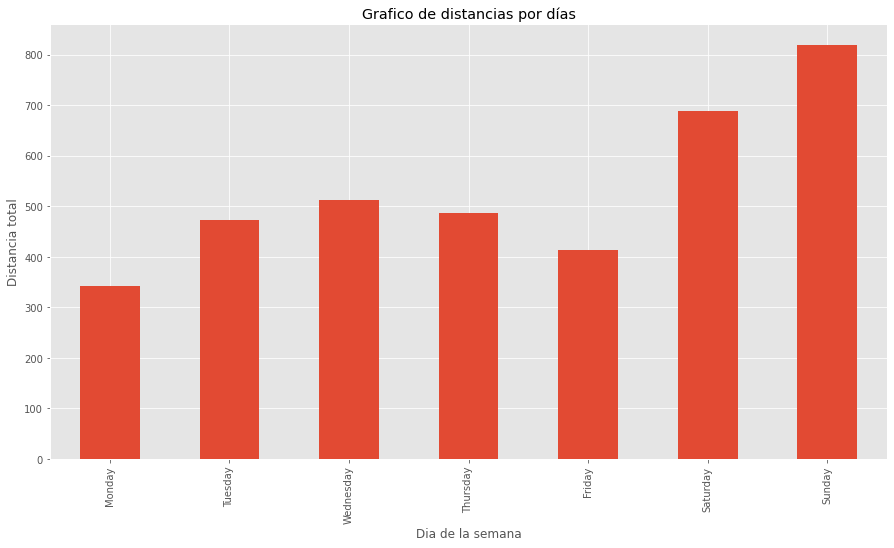

In [131]:
# Hago el groupby con la suma y reindexo por para ordenar
by_week_day = activities_run.groupby(['weekDayDate']).sum().reindex(days)

# Muestro los datos
print(by_week_day.distanceKm)

plt.figure(figsize=(15,8))

# Muestro la gráfica
by_week_day.distanceKm.plot(kind='bar',
                 title = 'Grafico de distancias por días',
                 ylabel='Distancia total',
                 xlabel='Dia de la semana')

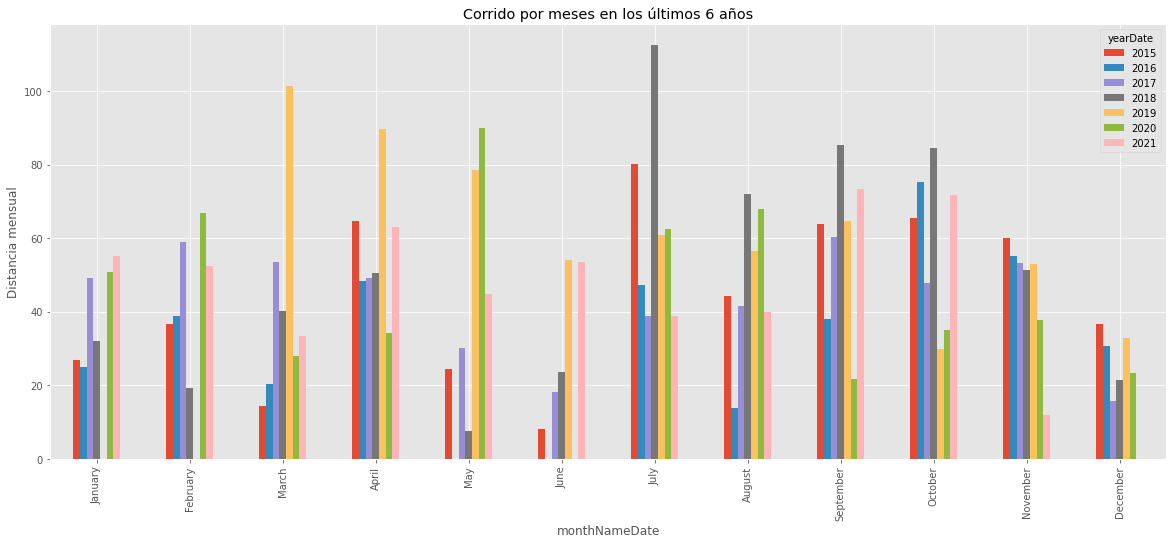

In [132]:
activities_run_15_21 = activities_run[activities_run.yearDate >= 2015]

by_month_year = activities_run_15_21.groupby(['monthNameDate', 'yearDate']).sum().distanceKm
by_month_year = pd.DataFrame(by_month_year)
by_month_year = by_month_year.reset_index()
by_month_year.head(5)
by_month_year.pivot("monthNameDate", 
                    "yearDate", 
                    "distanceKm").reindex(months).plot(kind='bar', 
                                                       figsize=(20,8), 
                                                       ylabel = 'Distancia mensual', 
                                                       title = 'Corrido por meses en los últimos 6 años')

##### Serie histórica de velocidad media por mes y año

In [155]:
# Agrupo por año y mes, guardando la media de velocidad
by_year_month_speed = activities_run_15_21.groupby(['yearDate', 'monthNameDate']).mean().averageSpeedKmh

# Reseteo indexado para convertir en columnas todo
by_year_month_speed = by_year_month_speed.reset_index()
# Redondeo la velocidad
by_year_month_speed.averageSpeedKmh = round(by_year_month_speed.averageSpeedKmh,1)
# Añado con index el mes
by_year_month_speed = by_year_month_speed.set_index('monthNameDate')
# Ordeno con la lista de meses y reseteo index de nuevo para dejar las tres columnas
by_year_month_speed = by_year_month_speed.loc[months].reset_index()
# Grafico
fig = px.line(by_year_month_speed, x='monthNameDate', y="averageSpeedKmh", color='yearDate')
fig.show()

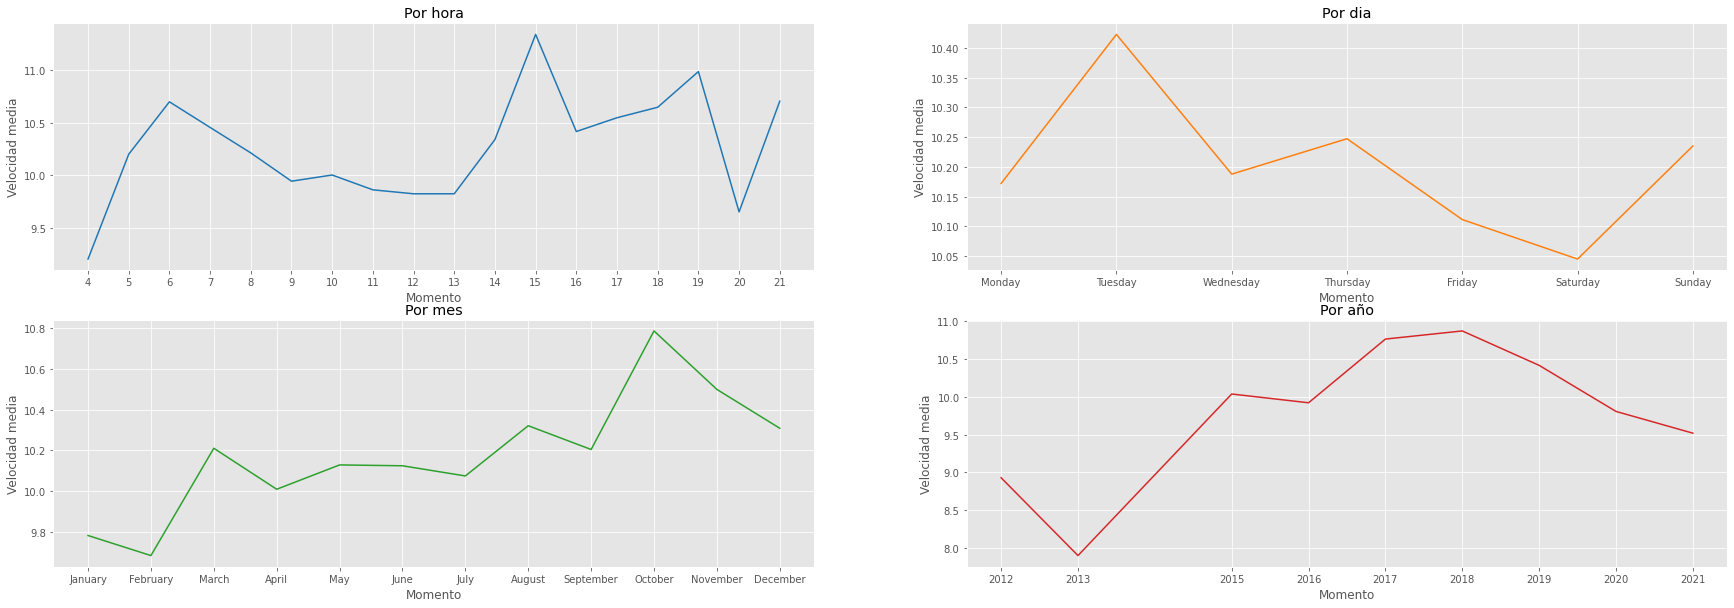

In [134]:
# Velocidad en diferentes tiempos
speed_by_hour = activities_run.groupby('hourDate').mean().averageSpeedKmh
speed_by_hour = pd.DataFrame(speed_by_hour).reset_index()
speed_by_day = activities_run.groupby('weekDayDate').mean().averageSpeedKmh
speed_by_day = pd.DataFrame(speed_by_day).reindex(days).reset_index()
speed_by_month = activities_run.groupby('monthNameDate').mean().averageSpeedKmh
speed_by_month = pd.DataFrame(speed_by_month).reindex(months).reset_index()
speed_by_year = activities_run.groupby('yearDate').mean().averageSpeedKmh
speed_by_year = pd.DataFrame(speed_by_year).reset_index()

fig, axs = plt.subplots(2, 2, figsize=(30,10))
axs[0, 0].plot(speed_by_hour.hourDate, speed_by_hour.averageSpeedKmh, 'tab:blue')
axs[0, 0].set_title('Por hora')
axs[0, 0].set_xticks(speed_by_hour.hourDate)
axs[0, 1].plot(speed_by_day.weekDayDate, speed_by_day.averageSpeedKmh, 'tab:orange')
axs[0, 1].set_title('Por dia')
axs[1, 0].plot(speed_by_month.monthNameDate, speed_by_month.averageSpeedKmh, 'tab:green')
axs[1, 0].set_title('Por mes')
axs[1, 1].plot(speed_by_year.yearDate, speed_by_year.averageSpeedKmh, 'tab:red')
axs[1, 1].set_title('Por año')
axs[1, 1].set_xticks(speed_by_year.yearDate)

for ax in axs.flat:
    ax.set(xlabel= 'Momento', ylabel='Velocidad media')

##### Acumulativo años

In [135]:
activities_run = activities_run.sort_values(by='startTimeLocal')
activities_run['cumsumByYear']=activities_run.groupby(['yearDate'])['distanceKm'].cumsum()
activities_run_cum = activities_run[['startTimeLocal', 'distanceKm','cumsumByYear', 'yearDate', 'yearDayDate']]
activities_run_cum = activities_run_cum[activities_run_cum.yearDate >= 2015]

In [136]:
fig = px.line(activities_run_cum, x="yearDayDate", y="cumsumByYear", color='yearDate')
fig.show()

# Estadística ciclismo

In [137]:
activities_bike = activities[activities.sportParent == 'cycling']

In [138]:
activities_bike.groupby('sport').count().activityId.sort_values(ascending = False)

sport
mountain_biking      69
cycling              27
road_biking          21
indoor_cycling       13
recumbent_cycling     1
Name: activityId, dtype: int64

#### Regresión lineal para cada uno de los tipos de actividades de 

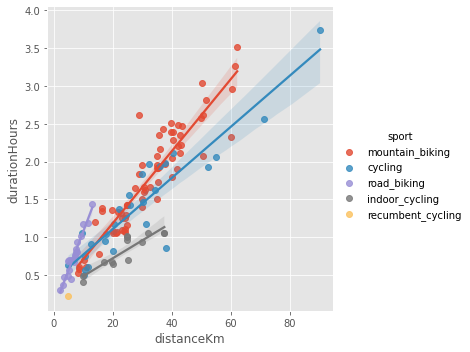

<Figure size 1080x576 with 0 Axes>

In [139]:
import seaborn as sns
sns.lmplot(x="distanceKm", y="durationHours", hue="sport", data=activities_bike)
plt.figure(figsize=(15,8))
plt.show()

weekDayDate
Monday        330.5
Tuesday       199.8
Wednesday     589.1
Thursday      353.0
Friday        203.3
Saturday     1117.1
Sunday        695.4
Name: distanceKm, dtype: float64


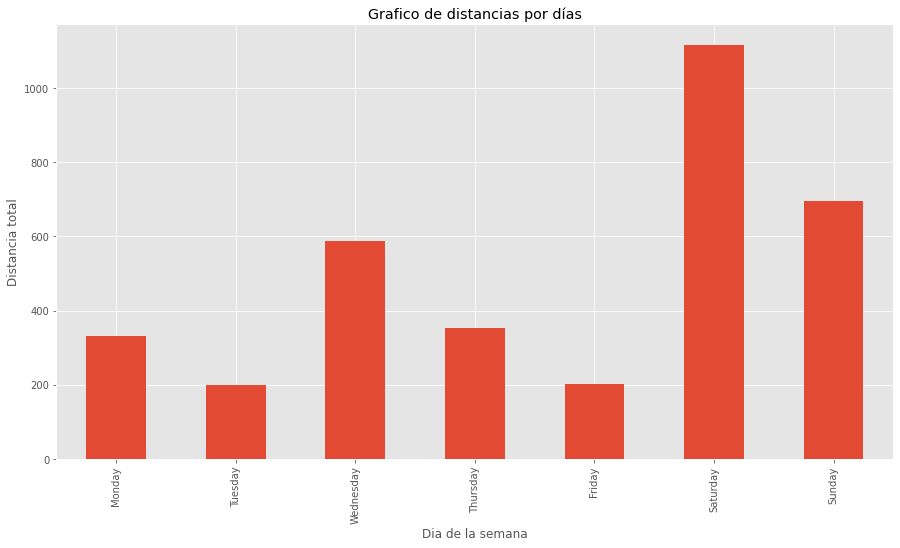

In [140]:
# Hago el groupby con la suma y reindexo por para ordenar
by_week_day = activities_bike.groupby(['weekDayDate']).sum().reindex(days)

# Muestro los datos
print(by_week_day.distanceKm)

plt.figure(figsize=(15,8))

# Muestro la gráfica
by_week_day.distanceKm.plot(kind='bar',
                 title = 'Grafico de distancias por días',
                 ylabel='Distancia total',
                 xlabel='Dia de la semana')


# Probabilidad

##### Probabilidad de que la velocidad media corriendo un sábado sea superior a 10Kmh

In [141]:
activities_run_sat = activities_run[activities_run.weekDayDate == 'Saturday']
prob = len(activities_run_sat[activities_run_sat.averageSpeedKmh > 10]) / len(activities_run_sat)
print("La probabilidad de correr a más de 10Kmh un sábado es del {}%".format(round(prob*100, 2)))

La probabilidad de correr a más de 10Kmh un sábado es del 53.92%


#### Probabilidad de correr al menos 8 km un día de diario

In [142]:
daily = ['Monday', 'Tuesday' , 'Wednesday', 'Thursday', 'Friday']
activities_run_daily = activities_run[activities_run.weekDayDate.isin(daily)]
prob = len(activities_run_daily[activities_run_daily.distanceKm > 8]) / len(activities_run_daily)
print("La probabilidad de correr al menos 8km un dia de dirario es del {}%".format(round(prob*100, 2)))

La probabilidad de correr al menos 8km un dia de dirario es del 17.65%


# Localización

#### Mapa de localización de las actividades

In [143]:
# Cargar folium y crear data
import folium

# Paso las coordenadas a decimales
activities['startLatitude'] = activities['startLatitude'].astype(float)
activities['startLongitude'] = activities['startLongitude'].astype(float)

# Paso el nombre a texto
activities['activityName'] = activities['activityName'].astype(str)

# Defino el mapa y su localización central
mapa = folium.Map(location=[activities['startLatitude'][0], activities['startLongitude'][0]] )

# Itero para elegir los colores por deporte y para ir creando los puntos
for i in range(len(activities)):
  if activities['sportParent'][i] == 'running':
    color = 'green'
  elif activities['sportParent'][i] == 'cycling':
    color = 'purple'
  elif activities['sportParent'][i] == 'walking':
    color = 'orange'
  elif activities['sportParent'][i] == 'swimming':
    color = 'blue'
  else:
    color = 'red'
  info = activities['activityName'][i] + ' ' + activities['sportParent'][i] + ' ' + str(activities['startTimeLocal'][i])
  folium.Marker(location=[activities['startLatitude'][i], activities['startLongitude'][i]], icon=folium.Icon(color= color), tooltip=activities['activityName'][i]).add_to(mapa)

mapa

##### 10 Localidades donde se han realizado más actividades

In [144]:
# Quito las actividades sin localización Lat-Lon 0 0 que coincide con Takoradi
activities_loc = activities[activities.cityLoc != 'Takoradi']
activities_loc.groupby('cityLoc').count().activityId.sort_values(ascending = False).head(10)

cityLoc
San Sebastian de los Reyes    546
Alcobendas                     76
Almorox                        72
Roquetas de Mar                22
Conil de la Frontera           10
Latina                          7
Morata de Tajuna                5
San Ildefonso                   4
Alcala de Henares               4
Guardamar del Segura            4
Name: activityId, dtype: int64

# Regresión lineal para rellenar las variables con nans
##### La frecuencia cardiaca y la elevationGain 

##### Frecuencia cardíaca

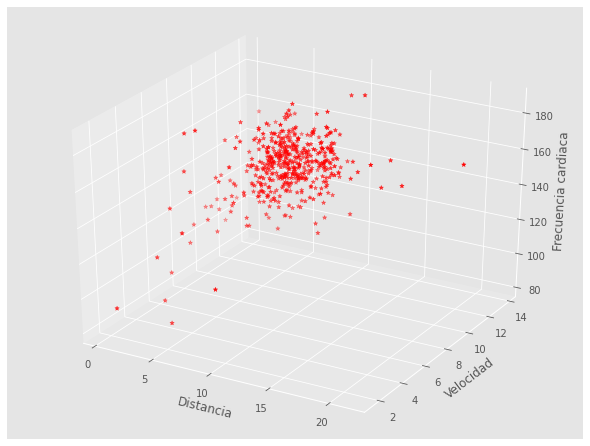

In [145]:
import statsmodels.api as sm           ## Este proporciona funciones para la estimación de muchos modelos estadísticos
import statsmodels.formula.api as smf  ## Permite ajustar modelos estadísticos utilizando fórmulas de estilo R
from mpl_toolkits.mplot3d import Axes3D 
activities_run_HR_notnull =  activities_run[(activities_run.averageHR.notnull()) & (activities_run.averageHR >= 75) ]
activities_select_run_lm = activities_run_HR_notnull[['averageHR',
                                            'distanceKm',
                                            'averageSpeedKmh']]

fig = plt.figure(figsize=(8, 6))       # Ajustes del gráfico
ax = Axes3D(fig)

x1 = activities_select_run_lm.distanceKm                             # Datos eje X
x2 = activities_select_run_lm.averageSpeedKmh                             # Datos eje Y
y = activities_select_run_lm.averageHR                              # Datos eje Z (Var. Respuesta)

ax.scatter(x1, x2, y, marker='*', c='r')
ax.set_xlabel('Distancia')        # Etiqueta del eje X
ax.set_ylabel('Velocidad')       # Etiqueta del eje Y
ax.set_zlabel('Frecuencia cardiaca');        # Etiqueta del eje Z (Var. Respuesta)

In [146]:
# Ajustar el modelo:
lm_HR = smf.ols('y ~ x1 + x2', data=activities_select_run_lm).fit()  # Ajusta el modelo usando el registro natural de uno de los regresores
print(lm_HR.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.213
Model:                            OLS   Adj. R-squared:                  0.209
Method:                 Least Squares   F-statistic:                     64.82
Date:                Thu, 11 Nov 2021   Prob (F-statistic):           1.20e-25
Time:                        14:39:59   Log-Likelihood:                -1897.5
No. Observations:                 483   AIC:                             3801.
Df Residuals:                     480   BIC:                             3814.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     98.8554      4.487     22.033      0.0

In [147]:
# Muestro coeficientes
lm_HR.params

Intercept    98.855379
x1            1.299220
x2            3.686649
dtype: float64

In [148]:
# Sustituyo en los missing y 0's
for i in range(len(activities_run)):
  if (np.isnan(activities_run.averageHR[i])) | (activities_run.averageHR[i] < 75):
    activities_run.averageHR[i] = lm_HR.params[0] + lm_HR.params[1] * activities_run.distanceKm[i] + lm_HR.params[2] * activities_run.averageSpeedKmh[i]

##### ElevationGain

In [149]:
activities_run_EG_notnull =  activities_run[(activities_run.elevationGain.notnull()) & (activities_run.elevationGain > 0) ]
activities_select_run_lm2 = activities_run_EG_notnull[['elevationGain',
                                            'distanceKm',
                                            'averageSpeedKmh',
                                            'calories']]

x1 = activities_select_run_lm2.distanceKm                             
x2 = activities_select_run_lm2.averageSpeedKmh                        
x3 = activities_select_run_lm2.calories   # Aunque no es significativa, pero por meter una variable más                             
y = activities_select_run_lm2.elevationGain                              

# Ajustar el modelo:
lm_EG = smf.ols('y ~ x1 + x2 + x3', data=activities_select_run_lm2).fit()  # Ajusta el modelo usando el registro natural de uno de los regresores
print(lm_EG.summary())

# Muestro coeficientes
print(lm_EG.params)

# Sustituyo en los missing y 0's
for i in range(len(activities_run)):
  if (np.isnan(activities_run.elevationGain[i])) | (activities_run.elevationGain[i] == 0):
    activities_run.elevationGain[i] = lm_EG.params[0] + lm_EG.params[1] * activities_run.distanceKm[i] + lm_EG.params[2] * activities_run.averageSpeedKmh[i] + lm_EG.params[3] * activities_run.calories[i]

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.469
Model:                            OLS   Adj. R-squared:                  0.466
Method:                 Least Squares   F-statistic:                     156.3
Date:                Thu, 11 Nov 2021   Prob (F-statistic):           1.44e-72
Time:                        14:39:59   Log-Likelihood:                -2573.8
No. Observations:                 534   AIC:                             5156.
Df Residuals:                     530   BIC:                             5173.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     45.2317     10.662      4.242      0.0

# Kmeans

In [150]:
# Librerias necesarias
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

In [151]:
activities_select_run = activities_run[['startTimeLocal',
                                       'weekendActivity',
                                       'morningActivity',
                                       'distanceKm',
                                       'durationHours',
                                       'averageSpeedKmh',
                                       'calories',
                                       'averageHR',
                                       'elevationGain']]

In [152]:
activities_select_run.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 553 entries, 552 to 0
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   startTimeLocal   553 non-null    datetime64[ns]
 1   weekendActivity  553 non-null    int64         
 2   morningActivity  553 non-null    int64         
 3   distanceKm       553 non-null    float64       
 4   durationHours    553 non-null    float64       
 5   averageSpeedKmh  553 non-null    float64       
 6   calories         553 non-null    float64       
 7   averageHR        553 non-null    float64       
 8   elevationGain    553 non-null    float64       
dtypes: datetime64[ns](1), float64(6), int64(2)
memory usage: 63.2 KB
